In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from dateutil.parser import parse
from datetime import datetime
import math
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

from sklearn.preprocessing import MinMaxScaler
import keras_tuner
import os
import tensorflow.keras as keras
from sklearn.model_selection import GridSearchCV

**---Data Preparation---**

In [2]:
# load all the data we need in the model
oil_data = pd.read_csv('WTI crude oil futures.csv',thousands=',')
oil_data['Date'] = pd.to_datetime(oil_data['Date'].apply(lambda x:parse(x).strftime('%Y-%m-%d')))
oil_data = oil_data.set_index('Date').sort_index()
oil_data = oil_data.astype(float)
oil_df = oil_data[['Close','Volume']]

# load time series of gold price
XAU_data = pd.read_csv('XAU_USD Historical Data-Daily.csv',thousands=',')
XAU_data['Date'] = pd.to_datetime(XAU_data['Date'].apply(lambda x:parse(x).strftime('%Y-%m-%d')))
XAU_data = XAU_data.set_index('Date').sort_index()

# load time series of interest rate
Interest_data = pd.read_csv('Federal Funds Composite Interest Rate Historical Data-Daily.csv',thousands=',')
Interest_data['Date'] = pd.to_datetime(Interest_data['Date'].apply(lambda x:parse(x).strftime('%Y-%m-%d')))
Interest_data = Interest_data.set_index('Date').sort_index()

# load time series of GBP-USD exchange rate
USD_data = pd.read_csv('GBP_USD Historical Data-Daily.csv',thousands=',')
USD_data['Date'] = pd.to_datetime(USD_data['Date'].apply(lambda x:parse(x).strftime('%Y-%m-%d')))
USD_data = USD_data.set_index('Date').sort_index()

USD_df = USD_data[['Price']]
USD_df.columns = ['USD']
XAU_df = XAU_data[['Price']]
XAU_df.columns = ['XAU']
INT_df = Interest_data[['Price']]
INT_df.columns = ['INT']

# cincatenate all the close prices
df_data = pd.concat([oil_df, USD_df,XAU_df], axis=1)
df_data = df_data.reindex(oil_df.index)
df_data = df_data.fillna(method='ffill')

In [27]:
df_data.iloc[:10,:]

,Close,Volume,USD,XAU
Date,,,,
2015-01-02,52.69,268708.0,1.5328,1189.18
2015-01-05,50.04,375782.0,1.5250,1204.45
2015-01-06,47.93,451642.0,1.5151,1219.20
2015-01-07,48.65,460083.0,1.5111,1210.80
2015-01-08,48.79,362081.0,1.5088,1208.98
2015-01-09,48.36,421007.0,1.5160,1223.40
2015-01-12,46.07,394946.0,1.5171,1233.64
2015-01-13,45.89,476541.0,1.5159,1230.88
2015-01-14,48.48,510252.0,1.5232,1229.95


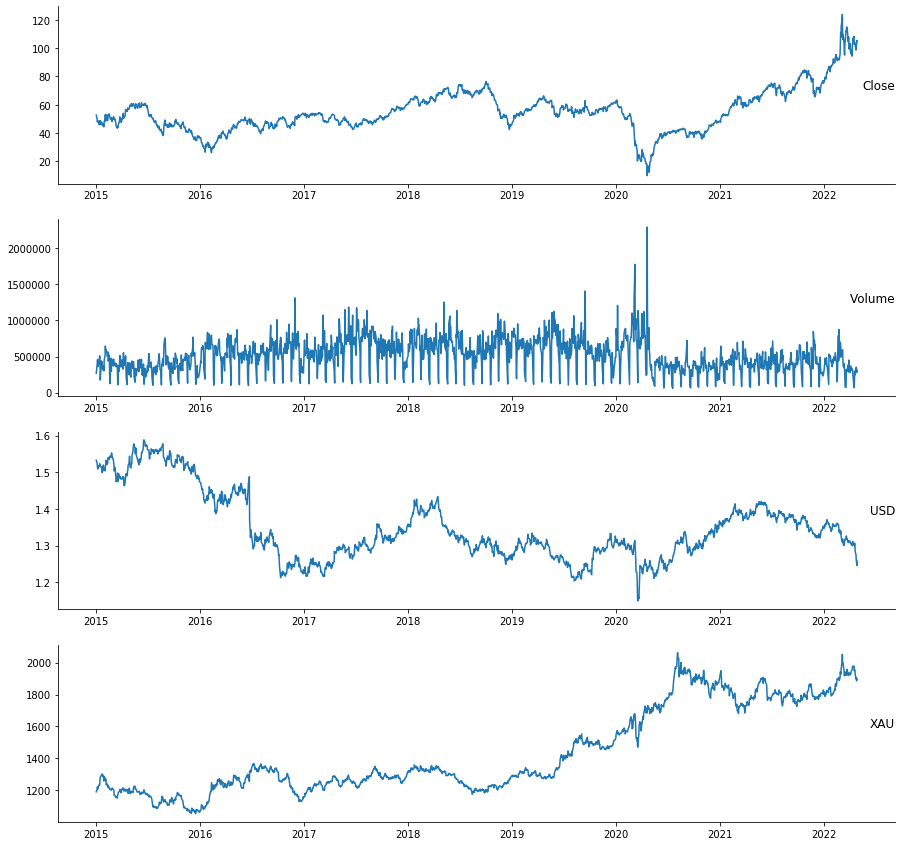

In [39]:
# plot all the time series
plt.figure(figsize = (15,15))
i=1
plt.title('Plots of variables in multivariate LSTM model')
for group in df_data.columns:
    plt.subplot(len(df_data.columns), 1, i)
    plt.plot(df_data[group])
    plt.title(group, y=0.5, loc='right')
    ax=plt.gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    i += 1
plt.savefig('Plots of variables in multivariate LSTM model',bbox_inches='tight')

In [3]:
# split training and testing set by 70% and 30%
training_size = int(len(df_data) * 0.7)
test_size = len(df_data) - training_size
train_data = df_data.iloc[0:training_size,:]
test_data = df_data.iloc[training_size:,:]

# apply MinMaxScaler to scale the time series into range of 0-1
scaler = MinMaxScaler(feature_range = (0,1))
train_data_scale = scaler.fit_transform(train_data)
test_data_scale = scaler.transform(test_data)

In [4]:
# create a function that transform the data to the structure for LSTM to learn
def dataset_create(data, timestep):
    data_X, data_Y = [], []
    for i in range(len(data) - timestep):
        data_X.append(data[i:(i+timestep),:])
        data_Y.append(data[i+timestep,0])
    return np.array(data_X), np.array(data_Y)

In [5]:
# set a fixed time step parameter as 50
timestep = 50
X_train, Y_train = dataset_create(train_data_scale, timestep)
X_test, Y_test = dataset_create(test_data_scale, timestep)

In [13]:
def build_model(hp):
    model = keras.Sequential()
    # set the list of units to be 32~256 with step of 8
    model.add(keras.layers.LSTM(units=hp.Int('units',min_value=32,
                                        max_value=256,
                                        step=8), 
                       activation='relu', input_shape=X_train.shape[-2:]))
    model.add(keras.layers.Dense(1))
    
    # set the list of learning rate to be 3 options as below
    model.compile(loss='mae', optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
                   metrics=['mae'])
    return model

# define model
trial_num = 10
bayesian_opt_tuner = keras_tuner.BayesianOptimization(
    build_model,
    objective ='mae',
    max_trials = trial_num,
    executions_per_trial = 1,
    directory = os.path.normpath('C:/Users/OliverG/Desktop/FYP/multi_var_tuner_result'),
    project_name = 'multi_var_WTI',
    overwrite=True)

# set epochs and batch size as fixed parameter due to lack of computing power
EPOCHS = 100
batch_size = 32
bayesian_opt_tuner.search(X_train, Y_train,
             epochs=EPOCHS,
             validation_data = (X_test,Y_test),
             validation_steps=len(X_test)//batch_size,
             steps_per_epoch=len(X_train)//batch_size,
             validation_split=0.2,verbose=1)

Trial 10 Complete [00h 05m 05s]
mae: 0.017284609377384186

Best mae So Far: 0.016998987644910812
Total elapsed time: 01h 21m 48s
INFO:tensorflow:Oracle triggered exit


In [18]:
import json

perf_dict = {}
# load all the trial history of Bayesian Optimizer
trials = bayesian_opt_tuner.oracle.trials
for i in range(trial_num):
    trial_id = ''
    if i < 10:
        trial_id = '0'+str(i)
    else:
        trial_id = str(i)
    directory = r'C:\Users\OliverG\Desktop\FYP\multi_var_tuner_result\multi_var_WTI\trial_'+trial_id+r'\trial.json'
    f = open(directory)
    trial_dict = json.load(f)
    perf_sum = trial_dict['hyperparameters']['values']
    print(str(perf_sum['units'])+' '+str(perf_sum['learning_rate']))
    trial_model = bayesian_opt_tuner.load_model(trials[trial_id])
    n_features = df_data.shape[1]
    train_predict = trial_model.predict(X_train)
    test_predict = trial_model.predict(X_test)
    # restructure the output data to the form that scaler could reverse
    train_predict_copy = np.repeat(train_predict, n_features, axis=-1)
    train_predict_inverse = scaler.inverse_transform(np.reshape(train_predict_copy,(len(train_predict),n_features)))[:,0]
    Y_train_copy = np.repeat(Y_train, n_features, axis=-1)
    Y_train_inverse = scaler.inverse_transform(np.reshape(Y_train_copy,(len(Y_train),n_features)))[:,0]
    # calculate RMSE of training data
    train_RMSE = math.sqrt(mean_squared_error(train_predict_inverse,Y_train_inverse))
    
    test_predict_copy = np.repeat(test_predict, n_features, axis=-1)
    test_predict_inverse = scaler.inverse_transform(np.reshape(test_predict_copy,(len(test_predict),n_features)))[:,0]
    Y_test_copy = np.repeat(Y_test, n_features, axis=-1)
    Y_test_inverse = scaler.inverse_transform(np.reshape(Y_test_copy,(len(Y_test),n_features)))[:,0]
    # calculate RMSE of training data
    test_RMSE = math.sqrt(mean_squared_error(test_predict_inverse,Y_test_inverse))
    # store all the results into a dictionary
    perf_dict[str(perf_sum['units'])+' '+str(perf_sum['learning_rate'])] = [train_RMSE,test_RMSE]
    f.close()
    
perf_dict

248 0.01
16/16 [==============================] - 1s 39ms/step
256 0.01
16/16 [==============================] - 1s 42ms/step
80 0.01
16/16 [==============================] - 0s 11ms/step
192 0.01
16/16 [==============================] - 0s 25ms/step
224 0.01
16/16 [==============================] - 0s 26ms/step
216 0.01
16/16 [==============================] - 0s 27ms/step
200 0.01
16/16 [==============================] - 0s 25ms/step
200 0.01
16/16 [==============================] - 0s 26ms/step
208 0.01


16/16 [==============================] - 0s 26ms/step
208 0.01
16/16 [==============================] - 0s 26ms/step


{'248 0.01': [1.125033990440758, 7.413813213787455],
 '256 0.01': [1.1412226409187705, 2.239409868815506],
 '80 0.01': [1.2810005591015265, 3.5470292053742853],
 '192 0.01': [1.1521209500553258, 3.578952827491922],
 '224 0.01': [1.2424072954488508, 2.3618733031706616],
 '216 0.01': [1.201436330769092, 2.6123148295957126],
 '200 0.01': [1.1214096241044988, 2.432427591631471],
 '208 0.01': [1.1732304987130973, 2.4609581249104573]}